# Analyse BlueSeis BSPF Event - Demo 0

Here we analyse the data for the 6-DoF station BSPF that we fetch online with FDSN services.

In [1]:
import os
import matplotlib.pyplot as plt
from obspy import UTCDateTime

from sixdegrees.sixdegrees import sixdegrees
from sixdegrees.plots.plot_cwt_all import *
from sixdegrees.plots.plot_velocities import *
from sixdegrees.plots.plot_spectra import *
from sixdegrees.plots.plot_backazimuth_results import *
from sixdegrees.plots.plot_cwt_all import *
from sixdegrees.plots.plot_waveform_cc import *


/home/andbro/Downloads/SixDegreesOfFreedom/sixdegrees/plots/plot_waveform_cc.py:409: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if wave_type is not "both":


## Configurations

Set configuration parameters for the event and data

In [2]:
config = {
    # Required time window parameters
    'tbeg': "2025-03-20 08:39:10",  # Start time
    'tend': "2025-03-20 08:39:40",  # End time
    
    # event
    'origin_time': "2025-03-20 03:39:05",
    'magnitude': 3.9,
    
    # Station coordinates (required)
    'station_lon': -116.455439,  # BSPF longitude
    'station_lat': 33.610643,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.BSPF..",     # Default seed ID
    'rot_seed': ["PY.BSPF..HJZ", "PY.BSPF..HJN", "PY.BSPF..HJE"],  # Rotation sensor seed ID
    'tra_seed': ["PY.PFOIX..HHZ", "PY.PFOIX..HHN", "PY.PFOIX..HHE"],  # Translation sensor seed ID
    
    # data source
    'data_source': "fdsn",
    'fdsn_client_rot': "IRIS",
    'fdsn_client_tra': "IRIS",

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./data/",  # Output directory

    # Project information
    'project': "BSPF_Analysis",  # Project name
    
    # Remove response
    'tra_remove_response': True,
    'rot_remove_response': True,

    # Rotate to ZNE
    'rotate_zne': True,

    # Optional parameters
    'verbose': True,            # Print detailed information
}

Initalize a sixdegrees object

In [3]:
sd = sixdegrees(conf=config)

Store the configuration as a pickle file

In [4]:
filename = "./config/"+f"config_BSPF_M{str(config['magnitude'])}_{config['tbeg'][:10].replace('-','')}" 

sd.store_as_yaml(config, filename)

 -> file ./config/config_BSPF_M3.9_20250320.yml already exists. Aborting...


Get key information about the event

In [5]:
ev = sd.get_event_info(
    origin_time=config['origin_time'],
    base_catalog="USGS",
    magnitude=config['magnitude']
)

Found event:
Origin time: 2025-03-20T03:39:38.220000Z
Magnitude: 3.85 md
Location: 18.419°N, -68.833°E
Depth: 151.0 km
Epicentral Distance: 5006.24 km
Epicentral Distance: 45.0°
Backazimuth: 97.29°


This will load the data from the specified data source:
- local mseed file
- local sds system
- fdsn (online)


In [6]:
sd.load_data(config['tbeg'], config['tend'])

-> fetching PY.PFOIX..HHZ data from FDSN
-> fetching PY.PFOIX..HHN data from FDSN
-> fetching PY.PFOIX..HHE data from FDSN
-> translation inventory requested: Inventory created at 2026-01-29T13:24:03.215700Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2025-03-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			PY
		Stations (1):
			PY.PFOIX (Pinyon Flats Observatory, IXBlue, CA, USA)
		Channels (27):
			PY.PFOIX..ACE, PY.PFOIX..BHZ, PY.PFOIX..BHN, PY.PFOIX..BHE, 
			PY.PFOIX..HHZ, PY.PFOIX..HHN, PY.PFOIX..HHE, PY.PFOIX..LCE, 
			PY.PFOIX..LCQ, PY.PFOIX..LHZ, PY.PFOIX..LHN, PY.PFOIX..LHE, 
			PY.PFOIX..LOG, PY.PFOIX..OCF, PY.PFOIX..VCO, PY.PFOIX..VEA, 
			PY.PFOIX..VEC, PY.PFOIX..VEP, PY.PFOIX..VKI, PY.PFOIX..VM0, 
			PY.PFOIX..VM1, PY.PFOIX..VM2, PY.PFOIX..VM3, PY.PFOIX..VM4, 
			PY.PFOIX..VM5, PY.PFOIX..VM6, PY.PFOIX..VPB
-> removing response: ACC
-> rotating translational data Z

Ensure that all traces of stream have the same sample size

In [7]:
sd.trim_stream(set_common=True, set_interpolate=False)

 -> stream size inconsistent: [6401, 6401, 6401, 6400, 6400, 6400]
  -> adjusted: [6400, 6400, 6400, 6400, 6400, 6400]


Now we can have a look at the waveforms of all 6 components

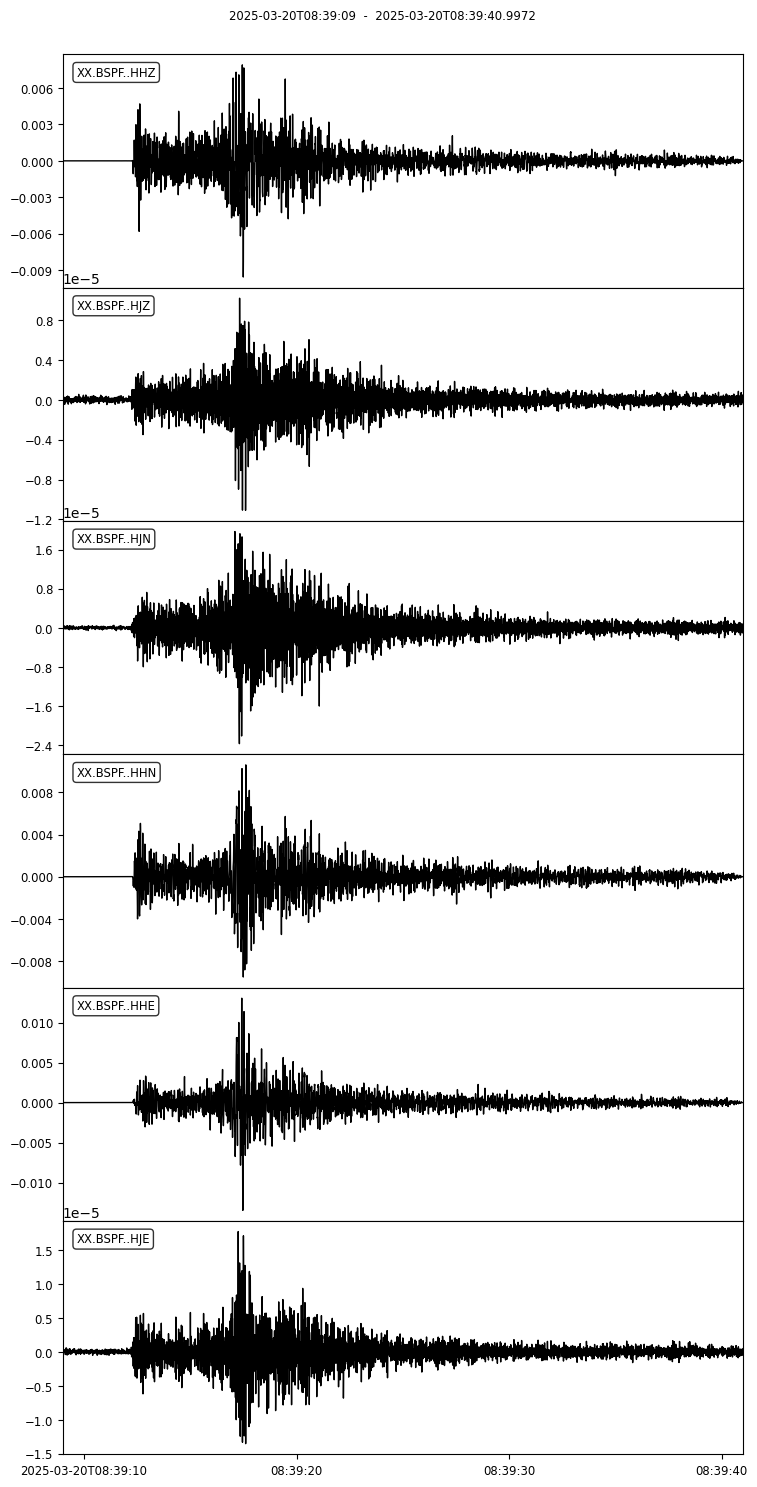

In [8]:
sd.st.plot(equal_scale=False);

### Write data to file or SDS system

This allows to write the data to a file or the SDS system. For the mseed file the seed id is as specified in the config.

In [9]:
# write to mseed file
# sd.st.write("./data/eventM35_6c.mseed", format="MSEED")

# write to sds filesystem
# sd.write_to_sds(sd.st, "./data/", format="MSEED")

## Analysis

### Wavelet Comparsion

This allows to compute the CWT for all components and plot the results.

In [10]:
# First compute CWT for all components
cwt_results = {}
for comp in ['Z', 'N', 'E']:
    # Rotation components
    rot_data = sd.get_stream("rotation", raw=True).select(channel=f"*{comp}")[0]
    cwt_results[f"{rot_data.stats.channel}"] = sixdegrees.compute_cwt(
        rot_data.times(), 
        rot_data.data, 
        rot_data.stats.delta,
        normalize=True
    )
    
    # Translation components
    acc_data = sd.get_stream("translation", raw=True).select(channel=f"*{comp}")[0]
    cwt_results[f"{acc_data.stats.channel}"] = sixdegrees.compute_cwt(
        acc_data.times(), 
        acc_data.data, 
        acc_data.stats.delta,
        normalize=True
    )


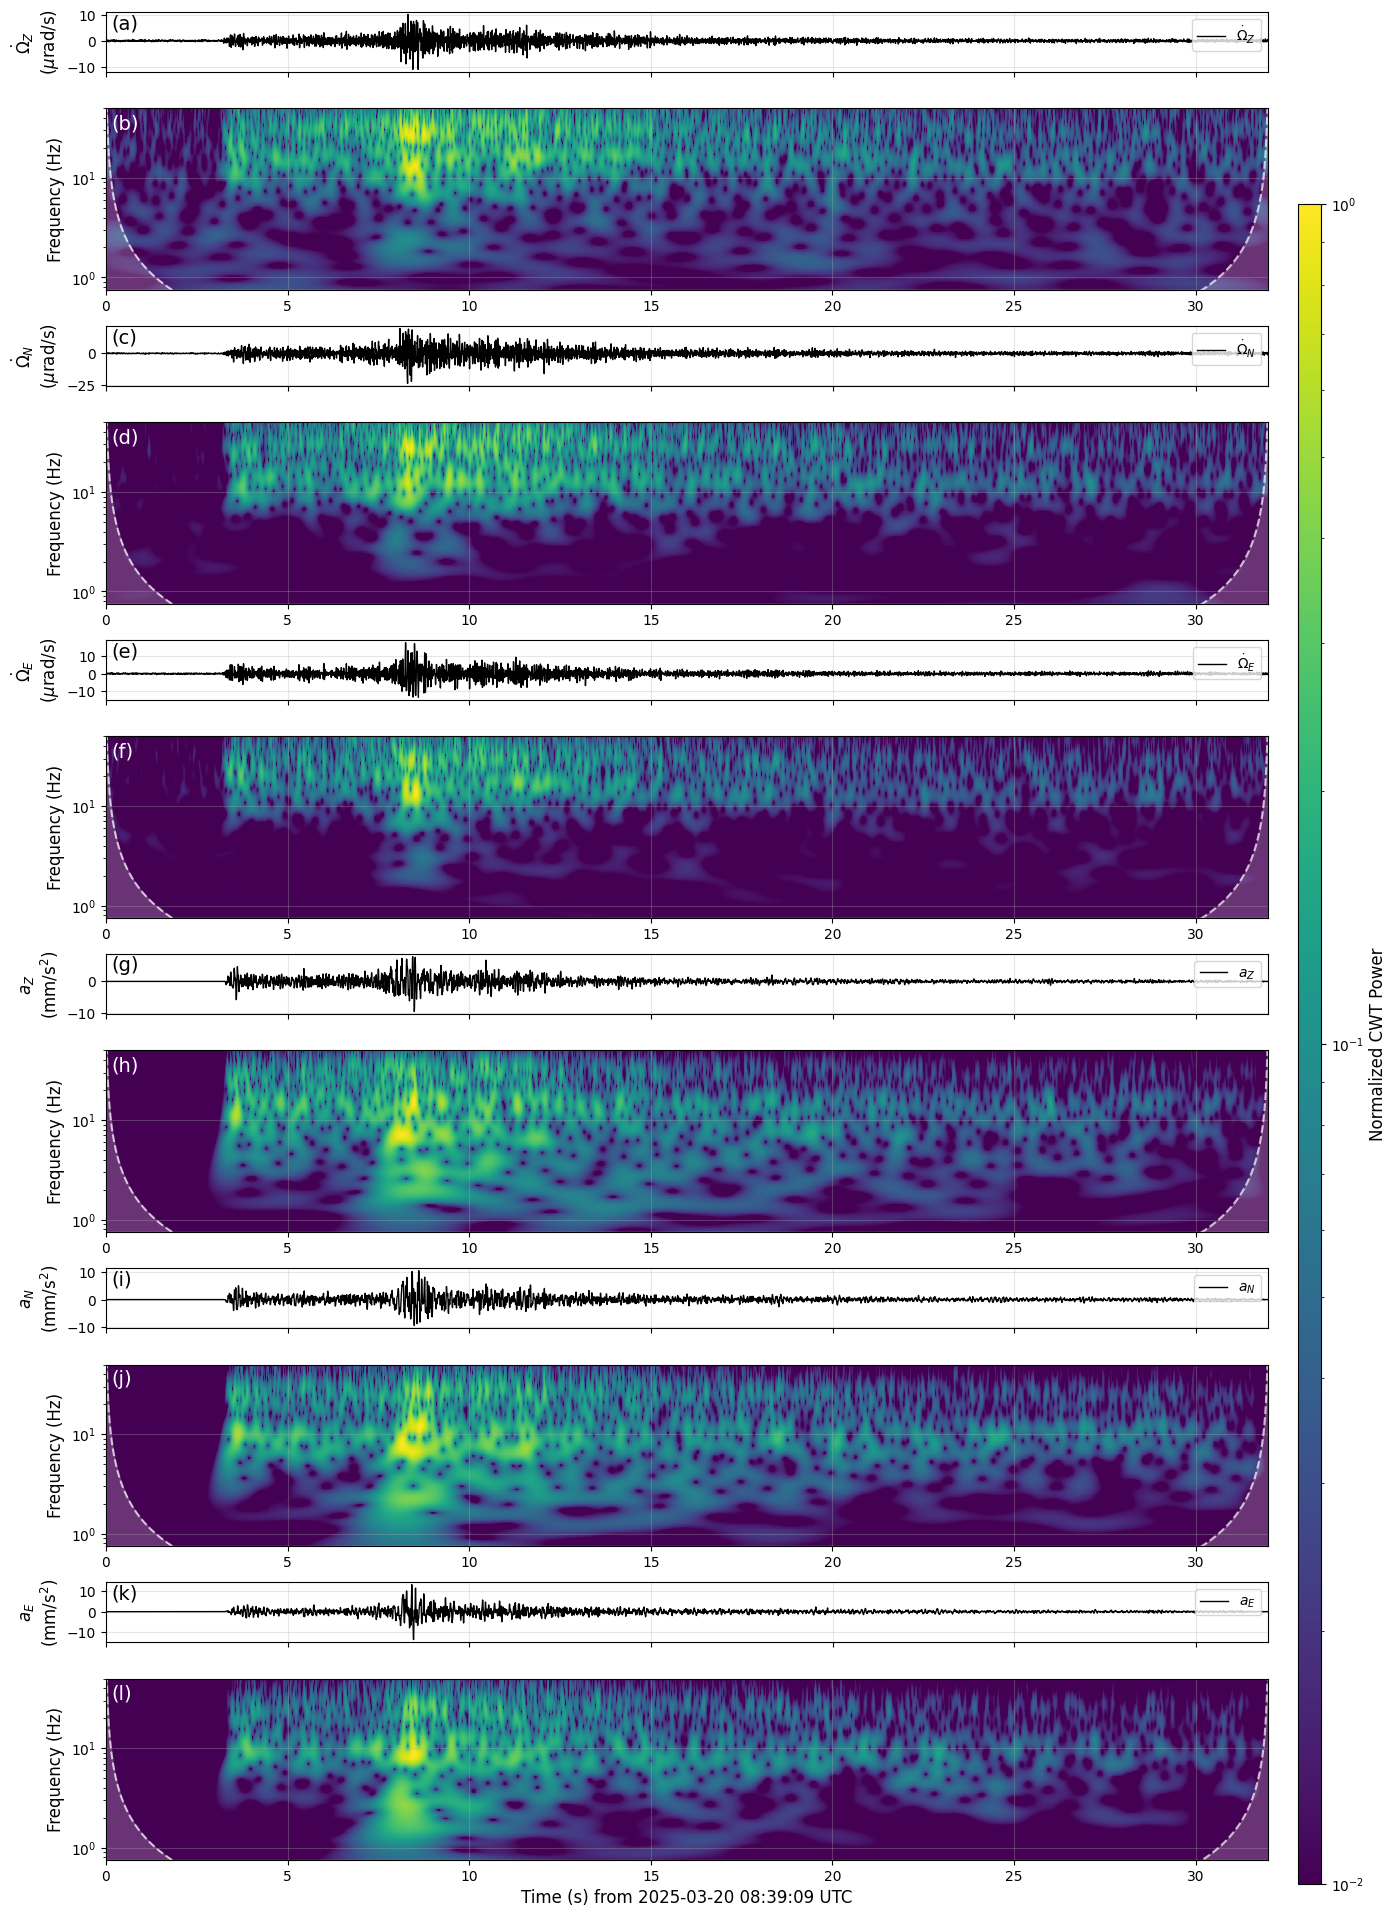

In [11]:

# Then plot all components
fig = plot_cwt_all(
    rot=sd.get_stream("rotation"),
    acc=sd.get_stream("translation"),
    cwt_output=cwt_results,
    clog=True,
    ylim=50
)

# fig.savefig("cwt_all.png")

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [12]:
sd.filter_data(fmin=0.5, fmax=10.0, output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [13]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

-> polarity for channel HZ changed from 1 to -1


Let's compare the waveforms of the rotation (red) and translational (black) components. According to the theory both should be in phase for plane waves, thus the cross-correlation should be close to 1.

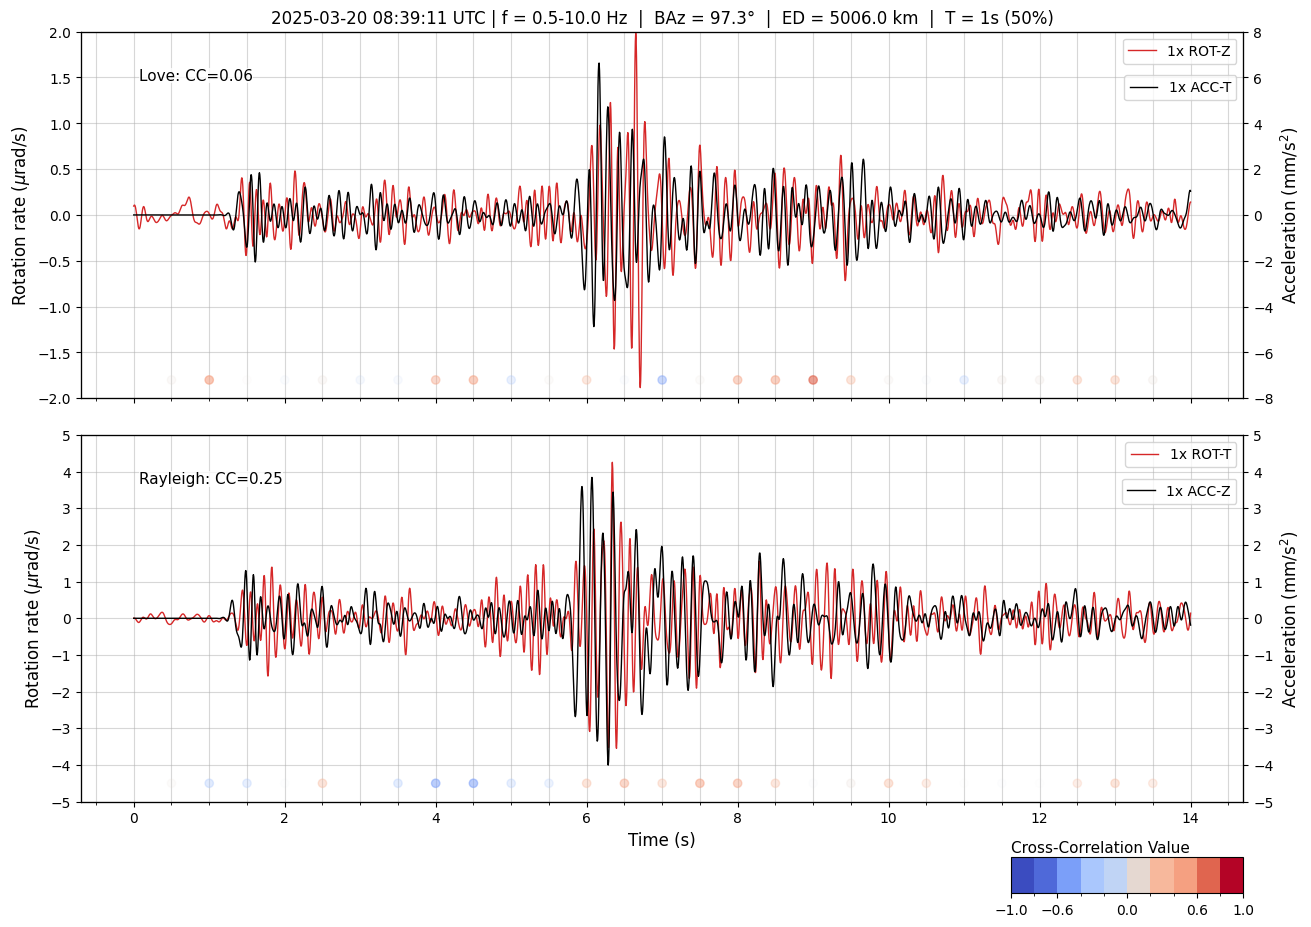

In [14]:
fig = plot_waveform_cc(
    sd_object=sd,
    twin_sec=1,
    twin_overlap=0.5,
    wave_type="both",
    unitscale="micro",
    t1=UTCDateTime(config['tbeg'])+1,
    t2=UTCDateTime(config['tend'])-15,
)

### Only required for time lag correction

This computes the time lag between the translation and rotation components based on cross-correlation for transverse and vertical component combinations. If correction is True, the time lag is applied to the rotation component.

In [16]:
# find (and correct) the time lag between translation and rotation data
sd.get_component_lag(
    normalize=True,
    baz=ev['backazimuth'],
    correct_traces=False
)


TypeError: unsupported format string passed to numpy.ndarray.__format__

Let's trim the data to the main event

In [17]:
sd.trim(UTCDateTime(config['tbeg'])+1, UTCDateTime(config['tend'])-15)

### Plot Spectra of Components

Here we can compare the FFT spetra of the rotation and translational components.

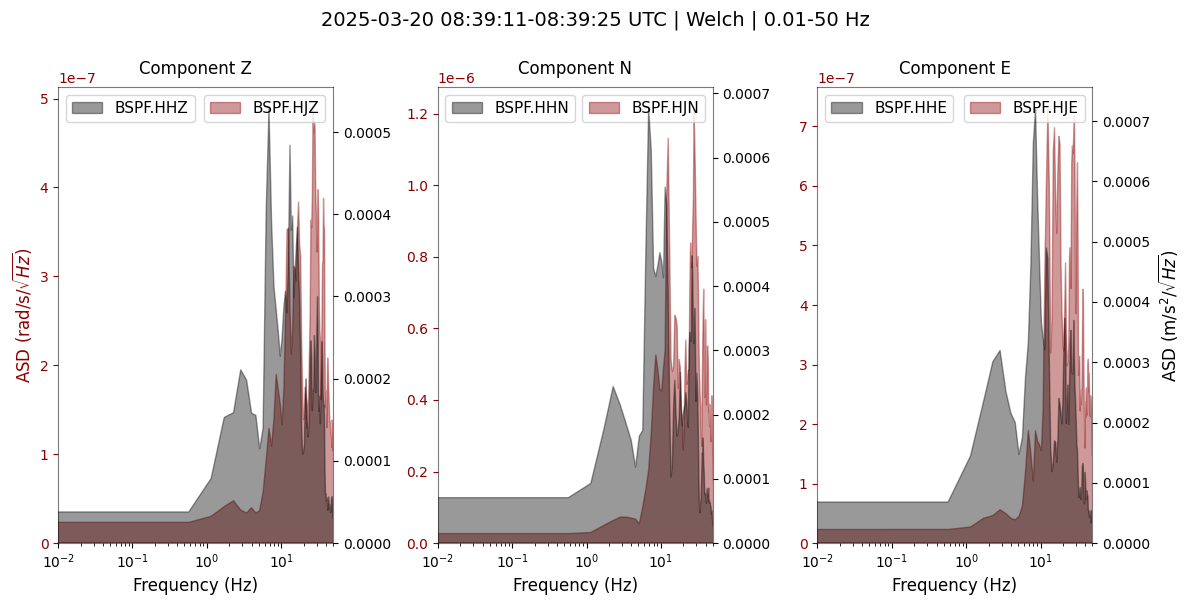

In [18]:
fig = plot_spectra(
    rot=sd.get_stream("rotation", raw=True).copy(),
    acc=sd.get_stream("translation", raw=True).copy(),
    method='welch',
    fmin=0.01,
    fmax=50,
    ylog=False,
    xlog=True,
    fill=True
)

### Backazimuth Estimate

Now we want to estimate the backazimuth of the event. We can do this by computing the cross-correlation between the rotation and translational components (representing Love and Rayleigh waves, respectively) for different backazimuths.

baz_max = 127, baz_std = 68


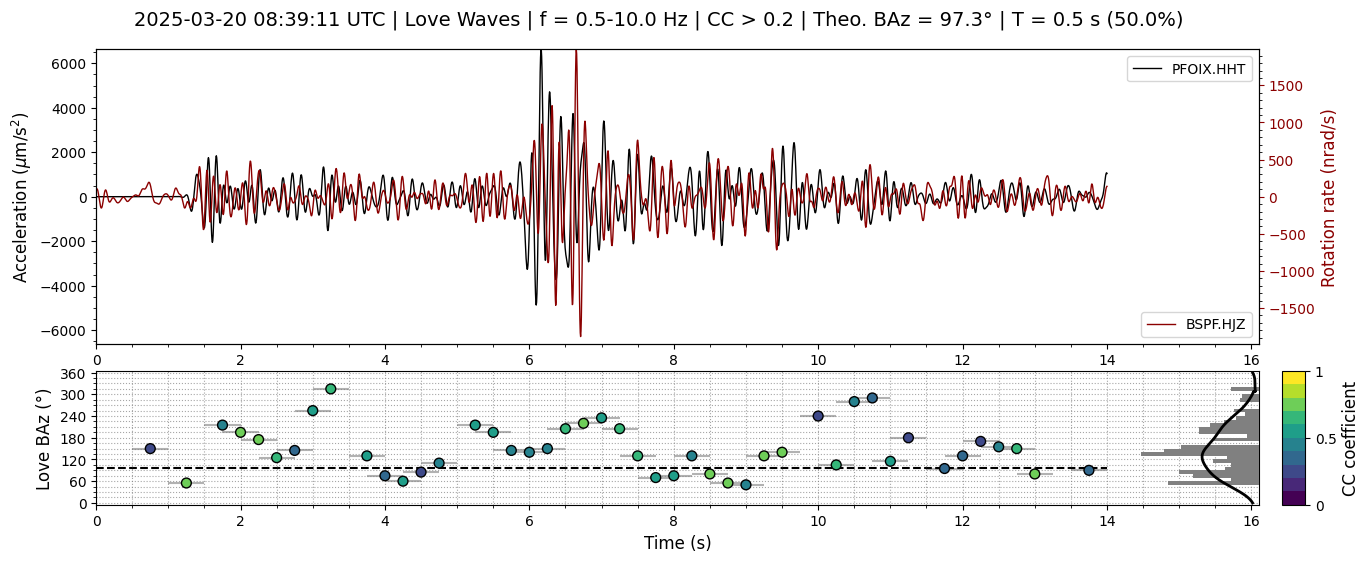

In [19]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='love',
    baz_step=5,
    baz_win_sec=0.5,
    baz_win_overlap=0.5,
    out=True
)

# Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results,
    wave_type='love',
    baz_theo=ev['backazimuth'],
    cc_threshold=0.2,  # optional
)

baz_max = 97, baz_std = 96


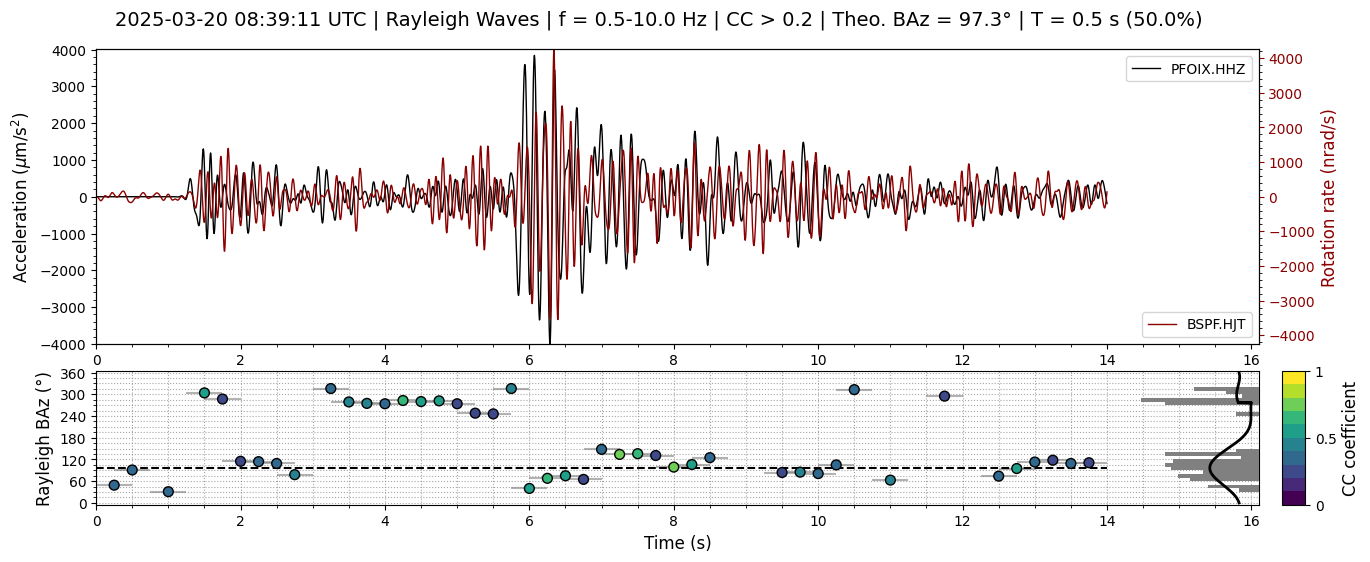

In [20]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='rayleigh',
    baz_step=1,
    baz_win_sec=0.5,
    baz_win_overlap=0.5,
    out=True
)

# # Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results,
    wave_type='rayleigh',
    baz_theo=ev['backazimuth'],
    cc_threshold=0.2,  # optional
)

We can also compare the different backazimuth estimation methods. This also includes a method based on the horizontal rotation components (called tangent method). This is then compared to the theoretical backazimuth (based on the event location).

Using precomputed love backazimuth results

Estimated BAz Love = 139° (CC ≥ 0.5)
Using precomputed rayleigh backazimuth results

Estimated BAz Rayleigh = 12° (CC ≥ 0.5)
Computing tangent wave backazimuth...

Estimated BAz Tangent = 91° (CC ≥ 0.5)


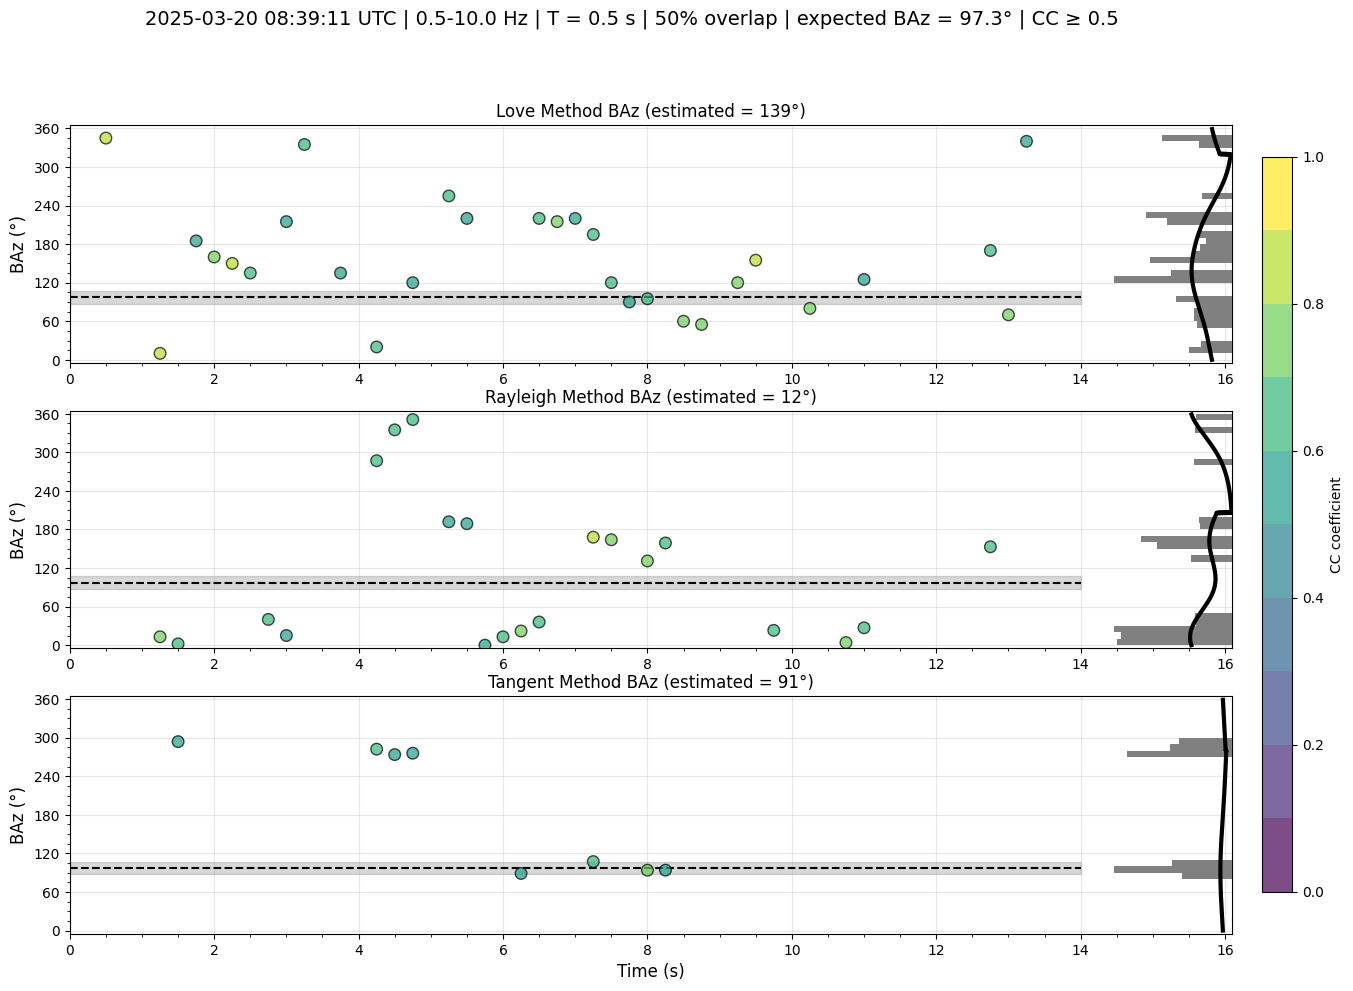

In [21]:
fig, _results = sd.compare_backazimuth_methods(
    Twin=0.5,
    Toverlap=0.5,
    cc_threshold=0.5,
    baz_theo=ev['backazimuth'],
    plot=True,
    output=True
)

### Analyse phase velocities

6 DoF observations allow us to estimate the phase velocities of Love and Rayleigh waves based on the amplitude ratios. For the estimation we use linear regression methods (ODR and RANSAC) to estimate the slope of rotational and translational amplitudes in time windows.


In [22]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=1.5,
    overlap=0.5,
    cc_threshold=0.4,
    method='odr',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=0.5,
    overlap=0.5,
    cc_threshold=0.4,
    method='odr',
    baz=ev['backazimuth']  # optional
)

We can plot the results with the waveforms which are rotated using the theoretical backazimuth.

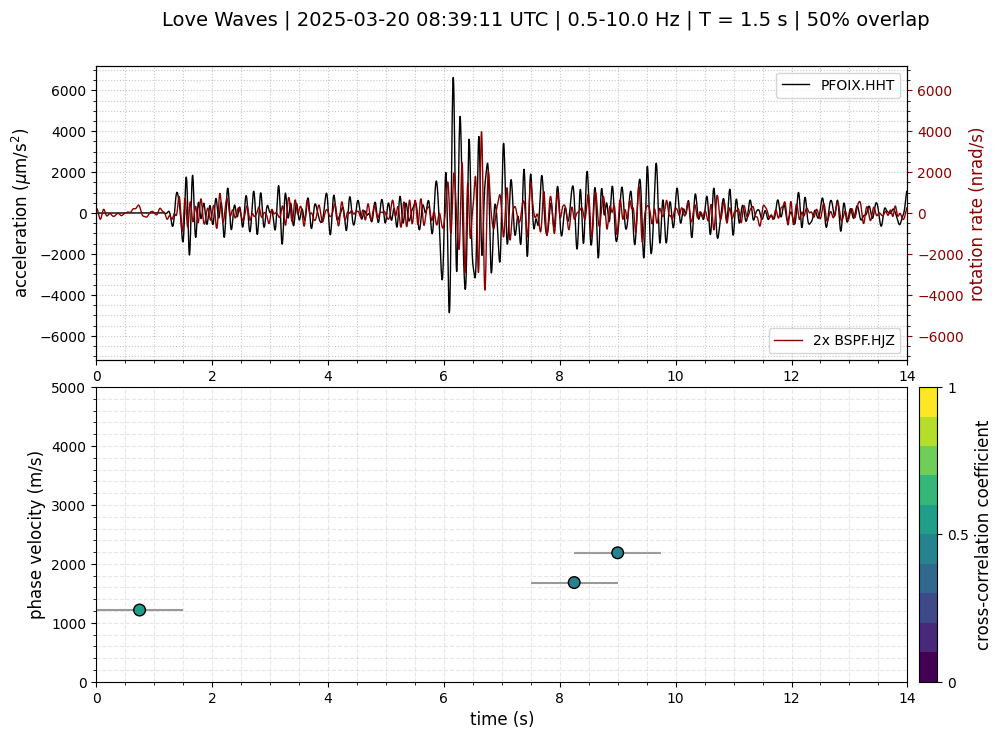

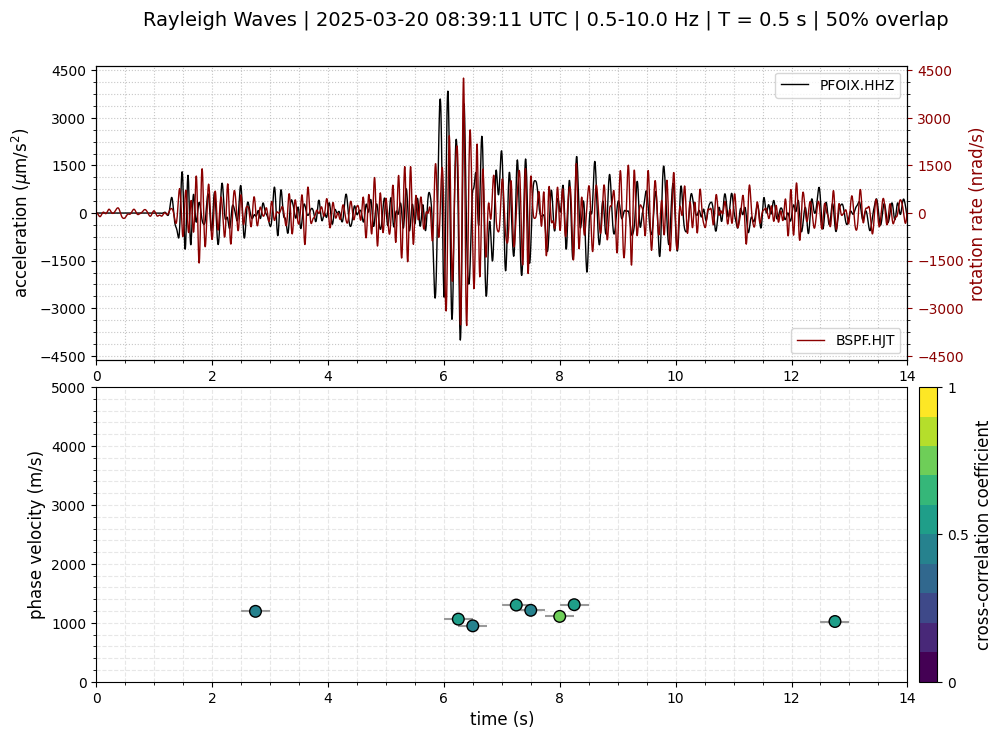

In [23]:
# Plot results
fig = plot_velocities(
    sd,
    velocity_results=love_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

# Plot results
fig = plot_velocities(
    sd,
    velocity_results=rayleigh_velocities,
    vmax=5000,  # optional
    minors=True # optional
)